In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf



plt.style.use('fivethirtyeight')


from Bio import SeqIO
from copy import deepcopy
from datetime import datetime
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model, model_from_json
from keras import backend as K
from keras import objectives

import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from keras.callbacks import EarlyStopping
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from random import sample

from Levenshtein import distance as levD
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D

import keras
import keras.layers as layers
import pennylane as qml

from collections import Counter
from copy import deepcopy
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import model_from_yaml

from sklearn.model_selection import train_test_split
from scipy.spatial import ConvexHull
from scipy.spatial.distance import euclidean as eucD

from Levenshtein import distance

import logging
from datetime import datetime
import pandas as pd
from Bio import SeqIO

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def load_sequence_and_metadata(kind="csv", datafile="data/20170531-H3N2-global.fasta", metadatafile="data/20170531-H3N2-global.tsv"):
    sequences = [
        s for s in SeqIO.parse(datafile, "fasta")
    ]
    if kind == "csv":
        metadata = pd.read_csv(
            metadatafile,
            sep="\t",
            parse_dates=["Collection Date"],
        )
  
    return sequences, metadata


def load_prediction_coordinates(datafile="data/oneQ_prediction_coords_with_colors.csv"):
    df = pd.read_csv(datafile , index_col=0 )
    return df


In [3]:
def right_pad(sequences):
    padded_sequences = deepcopy(sequences)
    seq_lengths = compute_seq_lengths(sequences)

    for s in padded_sequences:
        while len(s) < max(seq_lengths.keys()):
            s.seq += '*'
    return padded_sequences


def compute_seq_lengths(sequences):
    seq_lengths = [len(s) for s in sequences]
    seq_lengths = Counter(seq_lengths)
    return seq_lengths


def seq2chararray(sequences):
    padded_sequences = right_pad(sequences)
    seq_lengths = compute_seq_lengths(sequences)
    char_array = np.chararray(shape=(len(sequences), max(seq_lengths.keys())),
                              unicode=True)
    for i, seq in enumerate(padded_sequences):
        char_array[i, :] = list(seq)
    return char_array


def compute_alphabet(sequences):
    alphabet = set()
    for s in sequences:
        alphabet = alphabet.union(set(s))

    return alphabet


def encode_array(sequences):
    alphabet = compute_alphabet(sequences)
    seq_lengths = compute_seq_lengths(sequences)
    seq_array = seq2chararray(sequences)
    lb = LabelBinarizer()
    lb.fit(list(alphabet))
    print(len(alphabet))

    encoded_array = np.zeros(shape=(seq_array.shape[0],
                                    max(seq_lengths.keys()) * len(alphabet)))

    for i in range(seq_array.shape[1]):
        encoded_array[:, i*len(alphabet):(i+1)*len(alphabet)] = \
            lb.transform(seq_array[:, i])

    return encoded_array


def embedding2binary(decoder, predictions):
    return np.rint(decoder.predict(predictions))


def binary2chararray(sequences, binary_array):
    alphabet = compute_alphabet(sequences)
    seq_lengths = compute_seq_lengths(sequences)
    seq_array = seq2chararray(sequences)

    lb = LabelBinarizer()
    lb.fit(list(alphabet))

    char_array = np.chararray(shape=(len(binary_array),
                              max(seq_lengths.keys())), unicode=True)

    for i in range(seq_array.shape[1]):
        char_array[:, i] = lb.inverse_transform(
            binary_array[:, i*len(alphabet):(i+1)*len(alphabet)])

    return char_array


def save_model(model, path):
    with open(path + '.yaml', 'w+') as f:
        model_yaml = model.to_yaml()
        f.write(model_yaml)

    model.save_weights(path + '.h5')


def load_model(path):
    with open(path + '.yaml', 'r+') as f:
        yaml_rep = ''
        for l in f.readlines():
            yaml_rep += l

    model = model_from_yaml(yaml_rep)
    model.load_weights(path + '.h5')

    return model


def get_density_interval(percentage, array, axis=0):
    low = (100 - percentage) / 2
    high = (100 - low)

    lowp, highp = np.percentile(array, [low, high], axis=axis)

    return lowp, highp


In [4]:
sequences, metadata = load_sequence_and_metadata(kind='csv')
assert len(sequences) == len(metadata)

metadata = metadata[metadata['Host Species'] == 'IRD:Human']
training_metadata = metadata[metadata['Collection Date'] < datetime(2017, 1, 1)]
training_idxs = [i for i, s in enumerate(sequences) if s.id in training_metadata['Sequence Accession'].values]

test_metadata = metadata[metadata['Collection Date'] >= datetime(2017, 1, 1)]
test_idxs = [i for i, s in enumerate(sequences) if s.id in test_metadata['Sequence Accession'].values]

sequence_array = encode_array(sequences)
training_array = sequence_array[training_idxs]
test_array = sequence_array[test_idxs]

training_sequences = [sequences[i] for i in training_idxs]
test_sequences = [sequences[i] for i in test_idxs]

24


In [27]:
n_qubits = 6
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)


original_dim = training_array.shape[1]
intermediate_dim = 6
latent_dim = 3

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
quantum = qlayer(h) 
z_mean = layers.Dense(latent_dim)(quantum)
z_log_sigma = layers.Dense(latent_dim)(quantum)

from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])


encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

x_train, x_test = train_test_split(training_array)

early_stopping = EarlyStopping(monitor="val_loss", patience=2)

vae.fit(x_train, x_train,
        epochs=40,
        batch_size=32,
        validation_data=(x_test, x_test),)
        #callbacks=[early_stopping])


Epoch 1/40
314/314 [==============================] - 3s 9ms/step - loss: 3850.4650 - val_loss: 579.7770
Epoch 2/40
314/314 [==============================] - 2s 8ms/step - loss: 500.2200 - val_loss: 343.2468
Epoch 3/40
314/314 [==============================] - 2s 6ms/step - loss: 318.1831 - val_loss: 251.3577
Epoch 4/40
314/314 [==============================] - 2s 7ms/step - loss: 239.2993 - val_loss: 202.0238
Epoch 5/40
314/314 [==============================] - 2s 7ms/step - loss: 194.5376 - val_loss: 171.0797
Epoch 6/40
314/314 [==============================] - 2s 6ms/step - loss: 169.1792 - val_loss: 149.9141
Epoch 7/40
314/314 [==============================] - 2s 6ms/step - loss: 148.6026 - val_loss: 134.3614
Epoch 8/40
314/314 [==============================] - 2s 6ms/step - loss: 133.6888 - val_loss: 122.4858
Epoch 9/40
314/314 [==============================] - 2s 7ms/step - loss: 122.9410 - val_loss: 115.9686
Epoch 10/40
314/314 [==============================] - 2s 7ms/s

In [18]:
training_embeddings_mean = encoder.predict(training_array)[0]
test_embeddings_mean = encoder.predict(test_array)[0]
training_metadata.loc[:, 'coords0'] = training_embeddings_mean[:, 0]
training_metadata.loc[:, 'coords1'] = training_embeddings_mean[:, 1]
training_metadata.loc[:, 'coords2'] = training_embeddings_mean[:, 2]

tm_coords = deepcopy(training_metadata)  
tm_coords['coord0'] = training_embeddings_mean[:, 0]
tm_coords['coord1'] = training_embeddings_mean[:, 1]
tm_coords['coord2'] = training_embeddings_mean[:, 2]
avg_coords_by_day = tm_coords.groupby('Collection Date')\
                            [['coord0', 'coord1', 'coord2']].median()\
                            .resample("D").median().dropna().reset_index()

avg_coords_by_quarter = tm_coords.groupby('Collection Date')\
                            [['coord0', 'coord1', 'coord2']].median().\
                            resample("Q").median().dropna().reset_index()

        
avg_coords_by_week = tm_coords.groupby('Collection Date')\
                            [['coord0', 'coord1', 'coord2']].median().\
                            resample("W").median().dropna().reset_index()


avg_coords_by_quarter.to_csv("tdata.csv")
avg_coords_by_week.to_csv("tdata2.csv")
avg_coords_by_day.to_csv("tdata3.csv")


/opt/anaconda3/envs/QuantumVirus/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [19]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]


n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)


In [22]:


def create_dataset2(dataset, lookback=3):
    
    ldata = dataset.tolist()
    dataX, dataY = [], []
    for i in range(len(ldata)-lookback-1): 
        dataX.append(ldata[i:i+lookback])
        dataY.append(ldata[i+lookback+1])
    return numpy.array(dataX), numpy.array(dataY)
        
numpy.random.seed(7)


dataframe = read_csv('tdata3.csv', usecols=[2,3,4], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')


testdataframe = read_csv('testdata.csv', usecols=[1,2,3], engine='python')
test = testdataframe.values
test = test.astype('float32')


train = dataset


look_back = 3
trainX, trainY = create_dataset2(train, look_back)
testX, testY = create_dataset2(test, look_back)


trainX = numpy.reshape(trainX, (trainX.shape[0], 3, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 3, testX.shape[1]))


model = Sequential()
model.add(LSTM(4, input_shape=(3, look_back)))
model.add(qlayer) 
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=True)


Epoch 1/20
3283/3283 [==============================] - 4s 889us/step - loss: 1.2728
Epoch 2/20
3283/3283 [==============================] - 3s 868us/step - loss: 0.3022
Epoch 3/20
3283/3283 [==============================] - 3s 858us/step - loss: 0.1083
Epoch 4/20
3283/3283 [==============================] - 3s 875us/step - loss: 0.2137
Epoch 5/20
3283/3283 [==============================] - 3s 866us/step - loss: 0.2265
Epoch 6/20
3283/3283 [==============================] - 3s 892us/step - loss: 0.1795
Epoch 7/20
3283/3283 [==============================] - 3s 902us/step - loss: 0.1980
Epoch 8/20
3283/3283 [==============================] - 3s 891us/step - loss: 0.1791
Epoch 9/20
3283/3283 [==============================] - 3s 906us/step - loss: 0.2248
Epoch 10/20
3283/3283 [==============================] - 3s 900us/step - loss: 0.4792
Epoch 11/20
3283/3283 [==============================] - 3s 896us/step - loss: 0.1006
Epoch 12/20
3283/3283 [==============================] - 3s 885

In [23]:
classical_preds = [9, 9, 12, 8, 7, 7, 9, 9, 10, 7, 7, 7, 9, 9, 9, 12, 12, 11, 11, 10, 8, 8, 15, 10, 8, 8, 8, 11, 8, 11, 7, 12, 11, 12, 12, 7, 11, 11, 11, 12, 6, 11, 8, 12, 12, 7, 10, 10, 11, 13, 12, 11, 7, 11, 11, 7, 10, 11, 13, 13, 10, 10, 12, 10, 15, 7, 9, 10, 14, 11, 11, 11, 10, 10, 12, 15, 10, 9, 8, 11, 11, 12, 14, 11, 12, 10, 12, 10, 12, 15, 10, 9, 12, 15, 15, 13, 10, 11, 7, 7, 9, 12, 11, 11, 9, 11, 13, 12, 13, 10, 9, 9, 13, 9, 12, 11, 13, 12, 7, 11, 11, 7, 12, 9, 13, 11, 10, 7, 11, 7, 9, 12, 8, 7, 11, 11, 9, 11, 9, 9, 12, 10, 10, 10, 12, 11, 10, 10, 9, 8, 8, 19, 11, 12, 8, 11, 9, 9, 9, 7, 19, 11, 7, 7, 7, 7, 10, 10, 9, 12, 11, 11, 12, 8, 8, 8, 16, 9, 10, 7, 7, 12, 12, 11, 10, 13, 11, 9, 7, 7, 17, 17, 12, 13, 13, 12, 17, 8, 16, 12, 8, 8, 8, 11, 11, 11, 8, 8, 10, 9, 11, 11, 15, 15, 17, 17, 10, 10, 10, 15, 15, 15, 9, 16, 16, 9, 15, 15, 11, 11, 15, 15, 7, 10, 9, 9, 10, 10, 16, 16, 13, 12, 12, 8, 8, 13, 13, 8, 8, 8, 11, 11, 10, 13, 13, 8, 16, 10, 16, 16, 12, 12, 10, 15, 7, 13, 11, 10, 9, 10, 11, 10, 10, 12, 12, 9, 7, 9, 9, 10, 10, 8, 16, 12, 13, 9, 12, 11, 11, 9, 8, 9, 12, 14, 12, 15, 12, 10, 8, 9, 9, 11, 11, 11, 12, 12, 11, 7, 11, 13, 7, 7, 10, 13, 10, 10, 9, 9, 10, 9, 9, 13, 11, 12, 12, 12, 7, 12, 12, 11, 11, 12, 12, 12, 12, 8, 13, 13, 12, 11, 7, 9, 13, 9, 7, 10, 10, 8, 7, 7, 7, 13, 9, 10, 10, 13, 10, 12, 9, 8, 8, 14, 8, 8, 13, 13, 9, 11, 11, 11, 10, 10, 10, 10, 9, 12, 12, 10, 8, 10, 18, 12, 9, 11, 11, 14, 9, 14, 9, 9, 8, 8, 13, 13, 12, 7, 11, 12, 13, 12, 8, 10, 7, 11, 13, 13, 13, 10, 11, 7, 17, 13, 13, 19, 19, 12, 12, 11, 19, 8, 8, 11, 11, 11, 10, 10, 7, 7, 8, 9, 9, 9, 8, 8, 9, 8, 9, 9, 8, 8, 10, 17, 7, 7, 7, 7, 7, 7, 10, 7, 10, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12, 11, 11, 11, 9, 15, 9, 7, 8, 8, 15, 15, 8, 7, 7, 13, 13, 10, 10, 12, 12, 8, 8, 9, 10, 11, 11, 8, 9, 8, 9, 10, 7, 9, 11, 8, 11, 11, 12, 10, 13, 14, 9, 10, 10, 18, 18, 9, 9, 8, 8, 18, 13, 11, 11, 7, 9, 10, 10, 10, 8, 8, 15, 9, 12, 10, 10, 11, 9, 12, 7, 7, 10, 10, 14, 14, 9, 10, 10, 12, 9, 10, 13, 7, 12, 9, 11, 13, 11, 7, 7, 11, 8, 10, 11, 12, 13, 12, 12, 9, 12, 10, 11, 11, 12, 10, 9, 9, 8, 8, 12, 8, 12, 8, 8, 8, 8, 8, 8, 8, 11, 8, 8, 9, 13, 13, 11, 11, 12, 11, 10, 10, 11, 11, 8, 7, 11, 12, 8, 10, 10, 8, 11, 11, 11, 8, 8, 7, 12, 12, 8, 8, 9, 10, 8, 12, 8, 10, 10, 7, 7, 9, 9, 10, 11, 10, 10, 10, 11, 12, 12, 9, 15, 11, 8, 8, 12, 11, 11, 8, 10, 12, 12, 11, 10, 15, 15, 17, 17, 11, 11, 15, 15, 7, 17, 17, 17, 15, 11, 16, 10, 8, 12, 12, 10, 8, 11, 10, 11, 8, 8, 10, 11, 11, 11, 9, 8, 10, 12, 10, 10, 12, 12, 10, 10, 10, 10, 10, 10, 11, 11, 9, 7, 10, 10, 16, 16, 11, 8, 8, 7, 7, 12, 12, 11, 11, 7, 11, 12, 13, 16, 16, 10, 15, 11, 15, 10, 8, 8, 11, 7, 12, 8, 12, 8, 8, 11, 8, 8, 8, 7, 11, 12, 11, 11, 8, 9, 10, 12, 11, 11, 8, 11, 11, 8, 10, 7, 7, 7, 7, 11, 8, 10, 11, 9, 9, 12, 13, 13, 9, 9, 10, 12, 9, 11, 9, 12, 9, 9, 11, 11, 11, 16, 11, 11, 7, 13, 13, 12, 12, 12, 12, 11, 7, 10, 8, 10, 11, 8, 8, 8, 8, 11, 11, 16, 16, 10, 10, 11, 11, 7, 10, 10, 10, 11, 11, 11, 11, 10, 10, 12, 11, 15, 9, 11, 10, 8, 8, 8, 11, 11, 7, 9, 9, 8, 8, 10, 6, 6, 10, 10, 10, 11, 10, 8, 12, 10, 13, 12, 10, 10, 8, 10, 10, 12, 12, 8, 8, 7, 9, 8, 12, 13, 12, 15, 15, 7, 12, 12, 11, 13, 10, 12, 9, 10, 8, 9, 10, 9, 9, 9, 7, 11, 8, 11, 11, 8, 9, 7, 8, 9, 9, 13, 12, 10, 7, 10, 12, 10, 10, 8, 8, 13, 11, 11, 9, 12, 12, 11, 11, 11, 11, 11, 11, 8, 10, 10, 8, 10, 11, 11, 11, 13, 8, 15, 7, 7, 10, 10, 7, 12, 12, 8, 9, 10, 11, 8, 10, 12, 8, 9, 8, 12, 10, 12, 12, 9, 10, 11, 11, 11, 8, 11, 7, 9, 9, 11, 11, 11, 10, 15, 15, 10, 8, 11, 10, 8, 8, 10, 15, 15, 10, 12, 12, 11, 11, 10, 10, 12, 12, 15, 15, 7, 7, 8, 8, 7, 8, 11, 12, 12, 10, 11, 11, 11, 7, 11, 11, 11, 7, 11, 11, 10, 10, 11, 12, 11, 11, 11, 11, 9, 8, 8, 8, 12, 12, 11, 11, 8, 11, 9, 9, 8, 8, 9, 9, 8, 8, 10, 8, 8, 11, 11, 7, 6, 16, 11, 12, 12, 10, 12, 7, 7, 12, 9, 13, 7, 9, 11, 10, 10, 7, 10, 10, 13, 10, 13, 15, 15, 14, 11, 11, 11, 11, 10, 10, 8, 12, 11, 10, 15, 11, 8, 9, 7, 7, 12, 12, 8, 9, 13, 9, 8, 12, 8, 11, 11, 11, 11, 10, 11]
random_preds = [19, 13, 16, 18, 17, 17, 13, 13, 20, 17, 17, 17, 13, 13, 13, 20, 16, 15, 15, 14, 12, 18, 25, 14, 18, 18, 18, 15, 18, 15, 17, 16, 17, 16, 16, 17, 15, 15, 15, 16, 16, 15, 12, 16, 16, 17, 14, 14, 15, 17, 16, 21, 17, 15, 15, 17, 14, 15, 17, 17, 14, 14, 16, 20, 25, 17, 19, 14, 18, 15, 15, 15, 14, 14, 16, 25, 14, 13, 12, 15, 15, 16, 18, 15, 16, 14, 16, 14, 16, 25, 14, 13, 16, 25, 25, 17, 14, 15, 17, 17, 13, 16, 15, 15, 13, 15, 17, 16, 17, 14, 13, 19, 17, 13, 16, 17, 17, 16, 11, 15, 15, 17, 16, 13, 17, 15, 20, 17, 15, 17, 13, 16, 12, 17, 15, 15, 13, 15, 13, 13, 16, 14, 14, 14, 16, 15, 14, 14, 13, 18, 18, 29, 15, 16, 12, 15, 19, 19, 19, 17, 29, 15, 17, 17, 17, 17, 14, 14, 19, 16, 15, 15, 16, 12, 18, 18, 26, 13, 14, 17, 17, 15, 15, 15, 14, 17, 15, 13, 17, 17, 27, 27, 16, 17, 17, 16, 27, 18, 26, 16, 18, 18, 18, 15, 15, 15, 18, 18, 14, 19, 15, 15, 25, 25, 27, 27, 14, 14, 14, 25, 25, 25, 13, 26, 26, 13, 25, 25, 15, 15, 25, 25, 11, 14, 13, 13, 14, 14, 26, 26, 17, 16, 16, 18, 18, 17, 17, 18, 18, 18, 15, 15, 14, 17, 17, 18, 26, 14, 26, 26, 16, 16, 14, 25, 17, 17, 15, 14, 13, 14, 15, 14, 14, 16, 16, 13, 11, 19, 19, 14, 14, 18, 26, 20, 17, 19, 16, 15, 15, 19, 18, 19, 20, 18, 20, 19, 15, 14, 18, 13, 13, 15, 15, 15, 16, 16, 15, 17, 15, 21, 17, 17, 14, 17, 14, 14, 13, 13, 20, 19, 19, 17, 15, 16, 16, 16, 17, 16, 16, 15, 15, 16, 16, 16, 16, 18, 17, 17, 16, 15, 17, 13, 17, 19, 17, 14, 14, 12, 17, 17, 17, 18, 13, 14, 14, 17, 20, 16, 19, 18, 18, 18, 18, 18, 17, 17, 13, 15, 15, 15, 14, 14, 14, 19, 19, 16, 16, 14, 18, 14, 28, 16, 13, 20, 20, 18, 13, 18, 13, 13, 18, 18, 17, 17, 16, 17, 14, 16, 17, 15, 18, 14, 17, 15, 17, 17, 17, 14, 15, 17, 27, 21, 21, 29, 29, 16, 16, 15, 29, 17, 17, 15, 15, 15, 14, 14, 17, 17, 18, 19, 19, 19, 18, 18, 13, 18, 13, 13, 18, 18, 14, 27, 17, 17, 17, 17, 17, 17, 14, 17, 14, 13, 13, 13, 14, 14, 14, 15, 15, 15, 15, 16, 15, 15, 15, 13, 25, 13, 11, 17, 17, 25, 25, 18, 17, 17, 17, 17, 14, 14, 16, 16, 18, 18, 19, 14, 15, 15, 18, 13, 12, 13, 14, 17, 13, 15, 12, 15, 15, 16, 14, 17, 18, 19, 14, 14, 28, 28, 13, 13, 12, 12, 28, 17, 15, 15, 17, 13, 14, 20, 20, 18, 18, 25, 19, 16, 20, 20, 15, 13, 16, 17, 17, 14, 14, 18, 18, 13, 14, 14, 16, 13, 14, 17, 17, 16, 13, 15, 17, 15, 17, 17, 15, 16, 14, 15, 16, 17, 17, 17, 19, 16, 14, 15, 15, 16, 14, 17, 17, 18, 18, 15, 18, 16, 18, 18, 18, 18, 18, 18, 12, 15, 18, 18, 13, 17, 17, 15, 15, 16, 15, 14, 14, 15, 15, 12, 17, 15, 16, 18, 14, 14, 18, 15, 15, 15, 18, 18, 17, 16, 16, 18, 18, 19, 14, 18, 16, 12, 14, 14, 17, 17, 19, 19, 14, 15, 14, 14, 14, 15, 16, 16, 19, 25, 15, 12, 12, 16, 15, 15, 12, 14, 16, 16, 15, 14, 25, 25, 27, 27, 15, 15, 25, 25, 17, 27, 27, 27, 25, 15, 26, 14, 12, 16, 16, 14, 18, 15, 14, 19, 18, 18, 14, 15, 15, 15, 19, 18, 14, 16, 14, 14, 16, 16, 14, 14, 20, 20, 14, 14, 15, 15, 19, 17, 14, 14, 26, 26, 15, 18, 18, 17, 17, 16, 16, 15, 15, 17, 15, 16, 17, 26, 26, 20, 25, 15, 25, 14, 12, 18, 15, 17, 16, 18, 16, 18, 18, 15, 18, 18, 18, 17, 15, 16, 15, 15, 12, 19, 14, 16, 15, 15, 18, 15, 15, 18, 14, 17, 17, 17, 17, 15, 18, 20, 15, 13, 13, 16, 17, 17, 19, 13, 14, 16, 19, 15, 13, 16, 19, 19, 15, 15, 15, 26, 15, 15, 17, 17, 17, 16, 15, 16, 16, 15, 17, 14, 18, 14, 15, 18, 18, 12, 12, 15, 15, 26, 26, 14, 14, 15, 15, 17, 14, 14, 14, 15, 15, 15, 15, 14, 14, 16, 15, 25, 19, 15, 14, 18, 18, 12, 15, 15, 17, 13, 19, 18, 18, 14, 16, 16, 20, 14, 14, 15, 14, 18, 16, 14, 17, 16, 14, 14, 18, 14, 14, 16, 16, 18, 18, 17, 13, 18, 16, 17, 16, 25, 25, 17, 16, 16, 15, 17, 14, 16, 13, 14, 12, 13, 14, 13, 13, 13, 17, 15, 18, 15, 15, 12, 19, 17, 17, 19, 19, 17, 16, 14, 17, 14, 16, 14, 14, 18, 18, 17, 15, 15, 13, 16, 16, 15, 15, 15, 15, 15, 15, 17, 14, 14, 18, 14, 15, 15, 15, 17, 18, 25, 17, 17, 14, 14, 17, 16, 16, 18, 19, 14, 15, 18, 14, 16, 12, 19, 12, 16, 20, 16, 16, 19, 14, 15, 15, 15, 18, 15, 17, 13, 13, 15, 15, 15, 20, 25, 25, 14, 18, 15, 14, 18, 18, 14, 25, 25, 14, 16, 16, 15, 15, 14, 14, 16, 16, 25, 25, 17, 17, 18, 18, 17, 18, 15, 16, 16, 14, 15, 15, 15, 17, 15, 15, 15, 17, 15, 15, 20, 20, 15, 16, 15, 15, 15, 15, 13, 18, 18, 18, 16, 16, 15, 15, 12, 15, 13, 19, 18, 18, 13, 13, 18, 18, 14, 18, 18, 15, 15, 17, 16, 26, 15, 16, 16, 14, 16, 17, 13, 16, 13, 17, 17, 13, 15, 14, 14, 17, 14, 14, 17, 16, 17, 19, 19, 18, 15, 15, 15, 15, 14, 14, 18, 16, 15, 14, 25, 15, 18, 13, 16, 16, 16, 16, 18, 13, 17, 19, 18, 16, 18, 15, 15, 15, 15, 14, 15]

Text(0.5, 1.0, 'Quantum VAE + Quantum LSTM')

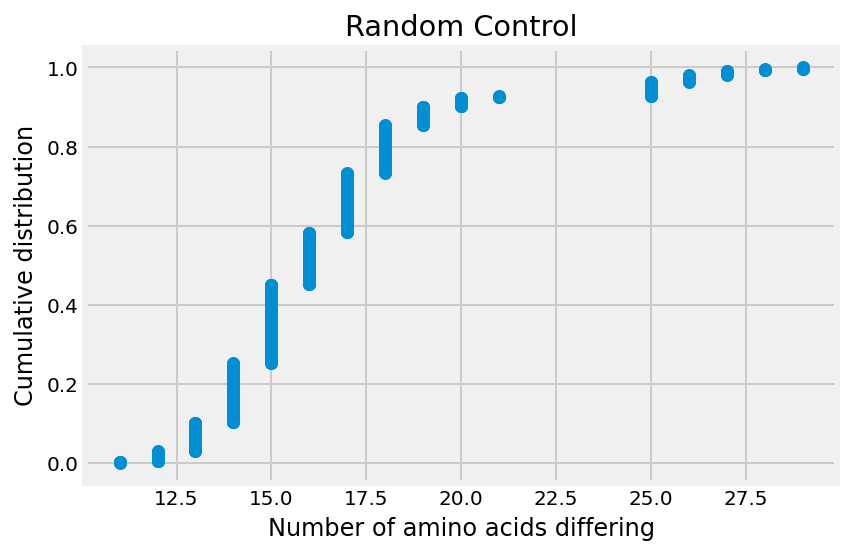

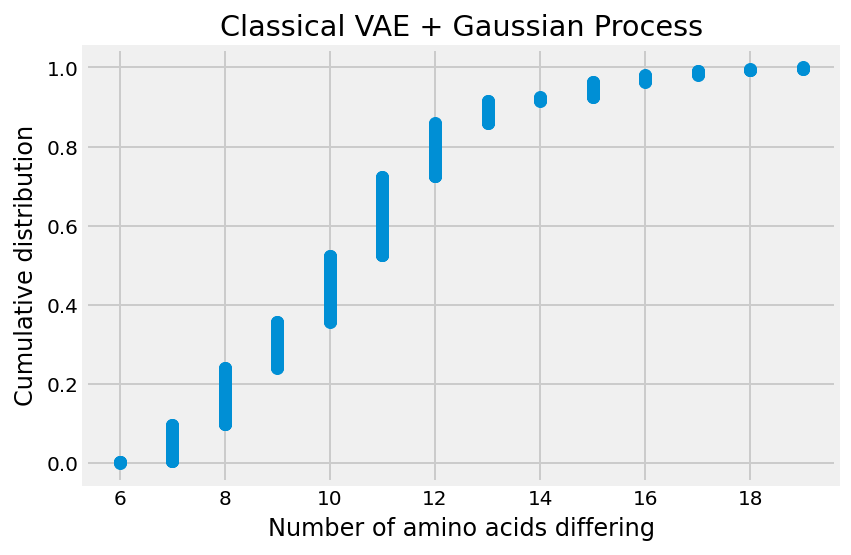

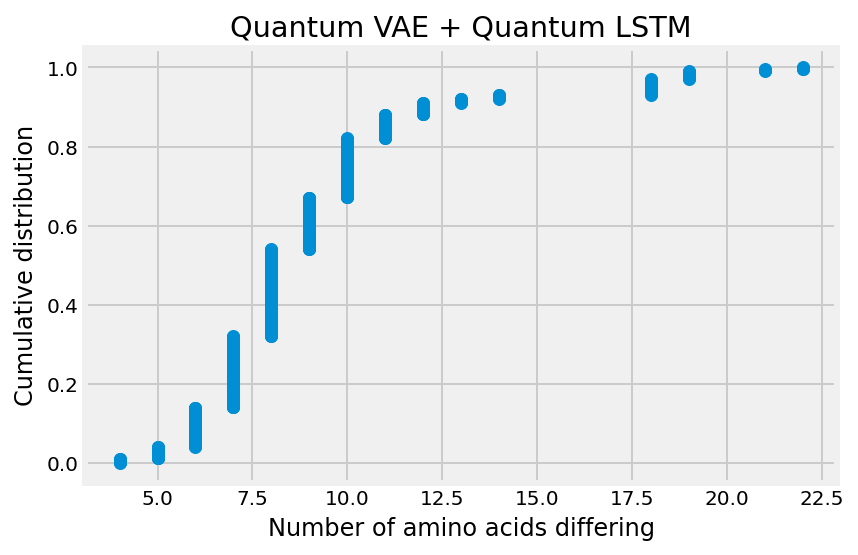

In [25]:
dat = np.array(test_embeddings_mean.tolist()[-3:])

pred = model.predict(dat.reshape(1, 3, 3) )

a = binary2chararray(sequences, embedding2binary(decoder, pred ))

most_probable_seq = ''.join(a[0])


from Levenshtein import distance
levDs_from_preds = [distance(str(record.seq), most_probable_seq) for record in test_sequences]

def ecdf_scatter(data):
    x, y = np.sort(data), np.arange(1, len(data)+1) / len(data)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x, y)
    
    return ax
    
ax = ecdf_scatter(random_preds)
ax.set_xlabel('Number of amino acids differing')
ax.set_ylabel('Cumulative distribution')
ax.set_title('Random Control')

bx = ecdf_scatter(classical_preds)
bx.set_xlabel('Number of amino acids differing')
bx.set_ylabel('Cumulative distribution')
bx.set_title('Classical VAE + Gaussian Process')

cx = ecdf_scatter(levDs_from_preds)
cx.set_xlabel('Number of amino acids differing')
cx.set_ylabel('Cumulative distribution')
cx.set_title('Quantum VAE + Quantum LSTM')
